$W(\theta)$

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from scipy import interpolate


from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.constants import c


import itertools

from halotools.mock_observables import angular_tpcf
import h5py

In [2]:
# load the data including scaling relation and luminosiy cut.
dat = np.load("sfr_catalog_0.258000_w_scaling_relations_masked_L41_pos400.npy", allow_pickle=True)


In [3]:
pos = dat['pos']
sfr = dat["sfr"]

This class **Converter_xyz_2_radeczred** is written by Shun Saito.

To convert the cartesian coordinates (x, y, z) to the sky coordinates(chi, ra, dec) and rotate about a pivot point to calculate $W(\theta)$

In [4]:
# Shun's code to get ra and dec from x,y,z:

def find_RotateM_3D(vec_a, vec_b):
    r"""
    calculate 3D rotation matrix from a vector a to a vector b.

    Parameters
    ----------
    vec_a, vec_b: array_like(shape=(3,))

    Return
    ------
    array_like(shape=(3,3))
    3 x 3 rotation matrix
    """
    vec_a /= np.linalg.norm(vec_a)
    vec_b /= np.linalg.norm(vec_b)
    c = np.dot(vec_a, vec_b)
    nu = np.cross(vec_a, vec_b)
    nu_cross = np.array([[0, -nu[2], nu[1]],
                         [nu[2], 0., -nu[0]],
                         [-nu[1], nu[0], 0.]])
    I = np.matrix(np.identity(3))
    return I + nu_cross + np.matmul(nu_cross, nu_cross) / (1. + c)

class Converter_xyz_2_radeczred():
    def __init__(self, Lbox, z_red, cp):
        # input parameters
        self.Lbox_sim = np.array(Lbox)
        self.z_red = z_red                 #redshift
        self.a_scale = 1./(1.+self.z_red ) #scale factor
        self.cp = cp                       #astropy cosmology object
        self.littleh = cp.H0.value/100.
        self.Mpcph = u.def_unit('Mpcph', u.Mpc/self.littleh) #[Mpc/h]
        
        _zz_min = 1.e-3
        _zz_max = 10.0
        _arr_zz = np.array(
            [_zz_min + (_zz_max - _zz_min) / 999. * i for i in range(1000)])
        _arr_chi = cp.comoving_distance(_arr_zz).to(self.Mpcph)  # [Mpc/h]
        self.func_redshift_to_chi = interpolate.InterpolatedUnivariateSpline(
             _arr_zz, _arr_chi)
        self.func_chi_to_redshift = interpolate.InterpolatedUnivariateSpline(
            _arr_chi, _arr_zz)
        return

    def find_rotation_to_pivot(self, ra_piv, dec_piv, z_piv):
        r"""
        calculate a 3D rotation matrix which translates (X,Y,Z) = (1,0,0)
        to the pivot (RA, DEC).

        Parameters
        ----------
        ra_piv, dec_piv: float*u.degree
                         pivot (RA, DEC) position on the 2D sky in units of [deg].

        z_piv: float
               must correspond tp the mimimum redshift.

        Return
        ------
        (Attribute)
        ra_piv, dec_piv, z_piv

        rot_ra, rot_dec: array_like(shape=(3,3))
                         3 x 3 rotation matrix where the operation order must be
                         rot_ra -> rot_dec
        """
        try:
            assert ra_piv.unit == u.degree
            assert dec_piv.unit == u.degree
        except AssertionError:
            msg = 'input (ra,dec) must be in usits of `u.degree`.'
            raise TypeError(msg)

        self.ra_piv = ra_piv
        self.dec_piv = dec_piv
        self.z_piv = z_piv
        self.chi_piv = self.cp.comoving_distance(z_piv).to(self.Mpcph)

        self.pos_piv = SkyCoord(ra=self.ra_piv, dec=self.dec_piv,
                                distance=self.chi_piv)

        self.rot_ra = find_RotateM_3D(
            [1, 0, 0], [np.cos(ra_piv), np.sin(ra_piv), 0])
        self.rot_dec = find_RotateM_3D([np.cos(ra_piv), np.sin(ra_piv), 0],
                                       [np.cos(ra_piv) * np.cos(dec_piv),
                                        np.sin(ra_piv) * np.cos(dec_piv), np.sin(dec_piv)])

        self.inv_rot_ra  = np.linalg.inv(self.rot_ra)
        self.inv_rot_dec = np.linalg.inv(self.rot_dec)
        
        return

    def rotate_3dvec_to_pivot(self, arr_vec):
        r"""
        rotate a 3-dimensional vector with the rotation matrix 
        calculated by `find_rotation_to_pivot`

        Parameters
        ----------
        arr_vec: array_like(shape=(N,3))

        Return
        ------
        arr_rotated: array_like(shape=(N,3))

        """
        try:
            assert self.ra_piv
        except AssertionError:
            msg = 'Should perform `find_rotation_to_pivot` in advance!'
            raise ValueError(msg)
            
        # RA rotation
        arr_tmp = np.einsum('ij, jk -> ik', self.rot_ra,
                            np.array([arr_vec[:,0], arr_vec[:,1], arr_vec[:,2]]))

        # DEC rotation
        arr_rotated = np.einsum('ij, jk -> ik', self.rot_dec,
                                np.array([arr_tmp[0,:], arr_tmp[1,:], arr_tmp[2,:]]))
        
        return arr_rotated.T
    

    def convert_skycoord_to_arrpos(self, skyc_pos):
        r"""
        convert from

        Parameters
        ----------
        skyc_pos: SkyCoord object (shape=(N,3))

        Return
        ------
        arr_pos: SkyCoord object

        """
        try:
            assert self.ra_piv
        except AssertionError:
            msg = 'Should perform `find_rotation_to_pivot` in advance!'
            raise ValueError(msg)


        arr_pos_X = skyc_pos.cartesian.x
        arr_pos_Y = skyc_pos.cartesian.y
        arr_pos_Z = skyc_pos.cartesian.z

        # inverse DEC rotation
        arr_rotated = np.einsum('ij, jk -> ik', self.inv_rot_dec,
                                np.array([arr_pos_X, arr_pos_Y, arr_pos_Z]))
        arr_pos_X = arr_rotated[0, :]
        arr_pos_Y = arr_rotated[1, :]
        arr_pos_Z = arr_rotated[2, :]

        # inverse RA rotation
        arr_rotated = np.einsum('ij, jk -> ik', self.inv_rot_ra,
                                np.array([arr_pos_X, arr_pos_Y, arr_pos_Z]))
        arr_pos_X = arr_rotated[0, :]
        arr_pos_Y = arr_rotated[1, :]
        arr_pos_Z = arr_rotated[2, :]

        
        # original (x,y,z)=(Lx/2, Ly/2, 0) should be traslated to
        # (X,Y,Z)=(chi_piv, 0, 0)
        arr_pos = np.zeros(shape=(arr_pos_X.shape[0],3))
        arr_pos[:, 0] = arr_pos_Y + self.Lbox_sim[0] / 2
        arr_pos[:, 1] = arr_pos_Z + self.Lbox_sim[1] / 2
        arr_pos[:, 2] = arr_pos_X - self.chi_piv.value
        
        return arr_pos

    def convert_arrpos_to_skycoord(self, arr_pos):
        r"""
        convert from 3D cartesian coordinates to Sky Coordinate

        Parameters
        ----------
        arr_pos: array_like(shape=(N,3))

        Return
        ------
        skyc_pos: SkyCoord object

        """
        try:
            assert self.ra_piv
        except AssertionError:
            msg = 'Should perform `find_rotation_to_pivot` in advance!'
            raise ValueError(msg)

        # Original (x,y,z)=(Lx/2, Ly/2, 0) should be traslated to
        # (X,Y,Z)=(chi_piv, 0, 0)
        arr_pos_X = arr_pos[:, 2] + self.chi_piv.value
        arr_pos_Y = arr_pos[:, 0] - self.Lbox_sim[0] / 2
        arr_pos_Z = arr_pos[:, 1] - self.Lbox_sim[1] / 2

        # RA rotation
        arr_rotated = np.einsum('ij, jk -> ik', self.rot_ra,
                                np.array([arr_pos_X, arr_pos_Y, arr_pos_Z]))
        arr_pos_X = arr_rotated[0, :]
        arr_pos_Y = arr_rotated[1, :]
        arr_pos_Z = arr_rotated[2, :]

        # DEC rotation
        arr_rotated = np.einsum('ij, jk -> ik', self.rot_dec,
                                np.array([arr_pos_X, arr_pos_Y, arr_pos_Z]))
        arr_pos_X = arr_rotated[0, :]
        arr_pos_Y = arr_rotated[1, :]
        arr_pos_Z = arr_rotated[2, :]

        # Now convert each grid position (X, Y, Z) to (ra, dec, comoving
        # ditance)
        skyc_pos = SkyCoord(x=arr_pos_X, y=arr_pos_Y, z=arr_pos_Z,
                            unit=self.Mpcph, representation_type='cartesian')
        skyc_pos.representation_type = 'spherical'
        return skyc_pos
    
    def calc_vr(self, arr_vorg, arr_skyc):
        """
        calculate the radial velocity in a new coordinate 
        from the original velocity [vx,vy,vz].
        
        v_r = (x*vx + y*vy + z*vz)/ r
        
        Parameters
        ----------
        arr_vorg: array_like(shape=(N,3))
        
        arr_skyc: array_like(shape=(N,3))
        
        Return
        ------
        arr_vr: array_like(shape=(N,))
        
        """
        
        v_xyz = self.rotate_3dvec_to_pivot(arr_vorg)
        
        chi = arr_skyc.distance.value
        arr_skyc.representation_type = 'cartesian'
        
        x = arr_skyc.x.value
        y = arr_skyc.y.value
        z = arr_skyc.z.value
        
        arr_vr = (x*v_xyz[:,0]+y*v_xyz[:,1]+z*v_xyz[:,2])/chi
        arr_skyc.representation_type = 'spherical'
        return arr_vr

In [5]:
a = 0.258000  #the scale factor is shown in the name of the data:  "sfr_catalog_0.258000.bin"
redshift = (1/a) -1
print(redshift)

2.875968992248062


In [6]:
Lbox = 400.

# choose cosmological parameters
cp = FlatLambdaCDM(H0=67.77, Om0=0.307115)
zred_sim = 2.88 # This is necessary only when you compute the redshift space distance (not implemented yet)

# create a class instance
Lbox_sim = np.array([Lbox,Lbox,Lbox]) 
conv = Converter_xyz_2_radeczred(Lbox_sim, zred_sim, cp)

# choose the pivot (ra, dec, z_red) where (x/2, y/2, 0) will be translated into.
ra_piv = 30*u.degree
dec_piv = 30*u.degree
zred_piv = 0.5
conv.find_rotation_to_pivot(ra_piv, dec_piv, zred_piv)


In [7]:
%%time


# Here I just run it for one example of alpha and beta:
alpha_values = np.array([105])
betaa_values = np.array([2e-4])


# Define the range of values for alpha and beta
#alpha_values = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100,
#                        105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180,
#                        185, 190, 195, 200])
#betaa_values = np.array([0.6e-4, 0.7e-4, 0.8e-4, 0.9e-4, 1e-4,
#                        1.1e-4, 1.2e-4, 1.3e-4, 1.4e-4, 1.5e-4, 1.6e-4, 1.7e-4, 1.8e-4, 1.9e-4, 2e-4,
#                        2.1e-4, 2.2e-4, 2.3e-4, 2.4e-4, 2.5e-4, 2.6e-4, 2.7e-4, 2.8e-4, 2.9e-4, 3e-4,
#                        3.1e-4, 3.2e-4, 3.3e-4, 3.4e-4, 3.5e-4, 3.6e-4, 3.7e-4, 3.8e-4, 3.9e-4, 4e-4,
#                        4.1e-4, 4.2e-4, 4.3e-4, 4.4e-4, 4.5e-4, 4.6e-4, 4.7e-4, 4.8e-4, 4.9e-4, 5e-4])



M_Sun = 1.9891e30
m_H = 1.67e-27  # in kg
beta_values = (betaa_values) / (4 * np.pi * m_H)

# Use itertools.product to generate all combinations
combinations = list(itertools.product(alpha_values, beta_values))



for alpha, beta in combinations:
    print(f"Processing alpha = {alpha}, beta = {beta}")

    # Specify the file paths
    file_path_esc_ISM = f'f_esc_ISM_alpha_{alpha}_beta_{beta}_a=0.258000_z=2.88.h5'
    
    # Open the HDF5 files
    with h5py.File(file_path_esc_ISM, 'r') as file_esc_ISM:
        # Access the datasets within the HDF5 files
        data_esc_ISM = file_esc_ISM['f_esc_Arr']
        #data_esc_IGM = file_esc_IGM['f_IGM']

        # Now, you can use the data as NumPy arrays
        np_data_esc_ISM = np.array(data_esc_ISM)
        #np_data_esc_IGM = np.array(data_esc_IGM)

    #print('f esc reading done!')
    
    # Lya luminosity
    L_int_Lya = 1.1e42 * sfr  #erg/s
    L_Lya = np_data_esc_ISM*L_int_Lya
    #L_Lya_igm = L_Lya*np_data_esc_IGM
    L_Lya[L_Lya==0] = 1e-15
    #L_Lya_igm[L_Lya_igm==0] = 1e-15

    #print('Lya luminosity done!')
    del np_data_esc_ISM, L_int_Lya
     
    mask_ISM = (L_Lya>=1*10**(42)) #& (pos[:,0] < 400) & (pos[:,0] > 0) & (pos[:,1] < 400) & (pos[:,1] > 0) & (pos[:,2] < 400) & (pos[:,2] > 0)
    #mask_IGM = (L_Lya_igm>=1*10**(41)) #& (pos[:,0] < 400) & (pos[:,0] > 0) & (pos[:,1] < 400) & (pos[:,1] > 0) & (pos[:,2] < 400) & (pos[:,2] > 0)

    laes_ISM = dat[mask_ISM]
    #laes_IGM = dat[mask_IGM] 
    
    #print('IGM/ISM masking done!')
    del mask_ISM
    
    
    pos_ISM = laes_ISM['pos']
    gals_cart_ISM = np.zeros(shape=(len(pos_ISM),3))
    gals_cart_ISM[:,0] = pos_ISM[:,0]
    gals_cart_ISM[:,1] = pos_ISM[:,1]
    gals_cart_ISM[:,2] = pos_ISM[:,2]
    gals_sky_ISM = conv.convert_arrpos_to_skycoord(gals_cart_ISM)
    ra_ISM = gals_sky_ISM.ra
    dec_ISM = gals_sky_ISM.dec

    #print('ra/dec ISM done!')
    del gals_cart_ISM, gals_sky_ISM
    
    # preparing randoms:

    fac = int(5) # factor of 5 more randoms than data
    num_data = len(pos_ISM)       #laes_new.shape[0]
    num_rand = num_data*fac #number of randoms
    rand_lae = np.zeros(shape=(num_rand,), dtype=np.dtype([('index',int),('x_ISM',np.float32),('y_ISM',np.float32),('z_ISM',np.float32)]))
    rand_lae['index'][:] = np.repeat(np.arange(num_data),fac)
    x_tmp = np.random.uniform(np.min(pos_ISM[:,0]),np.max(pos_ISM[:,0]),size=(int(num_rand),))
    rand_lae['x_ISM'][:] = x_tmp
    y_tmp = np.random.uniform(np.min(pos_ISM[:,1]),np.max(pos_ISM[:,1]),size=(int(num_rand),))
    rand_lae['y_ISM'][:] = y_tmp
    z_tmp = np.random.uniform(np.min(pos_ISM[:,2]),np.max(pos_ISM[:,2]),size=(int(num_rand),))
    rand_lae['z_ISM'][:] = z_tmp
    
    rand_x_ISM = rand_lae['x_ISM'][:]
    rand_y_ISM = rand_lae['y_ISM'][:]
    rand_z_ISM = rand_lae['z_ISM'][:]
    
    del rand_lae
    
    # now to convert randoms to ra and dec:

    rand_cart_ISM = np.zeros(shape=(num_rand,3))
    rand_cart_ISM[:,0] = rand_x_ISM
    rand_cart_ISM[:,1] = rand_y_ISM
    rand_cart_ISM[:,2] = rand_z_ISM
    rand_sky_ISM = conv.convert_arrpos_to_skycoord(rand_cart_ISM)
    rand_ra_ISM = rand_sky_ISM.ra
    rand_dec_ISM = rand_sky_ISM.dec
    
    angular_coords = np.vstack((ra_ISM,dec_ISM)).T
    rand_angular_coords = np.vstack((rand_ra_ISM,rand_dec_ISM)).T
    
    #print('random ra/dec ISM done!')
    del rand_cart_ISM, rand_ra_ISM, rand_dec_ISM
    
    
    theta_bins = np.logspace(-3.4899,-0.29,17)
    cen_theta_bins = (theta_bins[:-1]+theta_bins[1:])/2.0
    
    w_theta_with_randoms_ISM = angular_tpcf(angular_coords, theta_bins, randoms=rand_angular_coords, estimator='Landy-Szalay' ,num_threads='max')
    
    #print('w(theta) ISM done!')
    
    bin_centers = 0.5*(theta_bins[1:]+theta_bins[:-1])
    theta_arcsec = bin_centers*3600  #arcsec
    
    np.savetxt('halotools_w_theta_Landy-Szalay_ISM_alpha_'+str(alpha)+'_beta_'+str(beta)+'_a=0.258000_z=2.88.txt',np.column_stack((theta_arcsec,w_theta_with_randoms_ISM)))



Processing alpha = 105, beta = 9.530236113287146e+21


CPU times: user 613 ms, sys: 363 ms, total: 975 ms
Wall time: 15.2 s


Processing alpha = 105, beta = 9.530236113287146e+21
CPU times: user 567 ms, sys: 291 ms, total: 858 ms
Wall time: 8.82 s


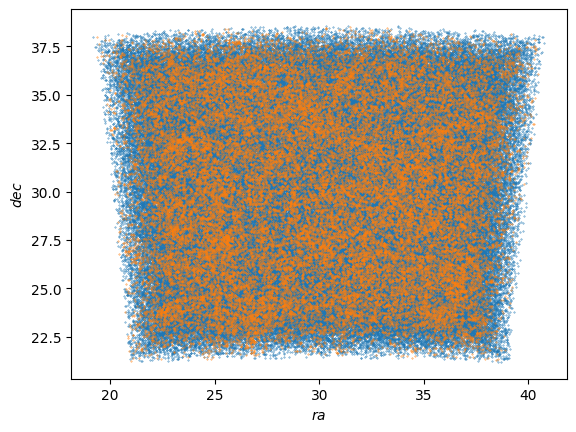

In [8]:
%%time


# Here I just run it for one example of alpha and beta:
alpha_values = np.array([105])
betaa_values = np.array([2e-4])


# Define the range of values for alpha and beta
#alpha_values = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100,
#                        105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180,
#                        185, 190, 195, 200])
#betaa_values = np.array([0.6e-4, 0.7e-4, 0.8e-4, 0.9e-4, 1e-4,
#                        1.1e-4, 1.2e-4, 1.3e-4, 1.4e-4, 1.5e-4, 1.6e-4, 1.7e-4, 1.8e-4, 1.9e-4, 2e-4,
#                        2.1e-4, 2.2e-4, 2.3e-4, 2.4e-4, 2.5e-4, 2.6e-4, 2.7e-4, 2.8e-4, 2.9e-4, 3e-4,
#                        3.1e-4, 3.2e-4, 3.3e-4, 3.4e-4, 3.5e-4, 3.6e-4, 3.7e-4, 3.8e-4, 3.9e-4, 4e-4,
#                        4.1e-4, 4.2e-4, 4.3e-4, 4.4e-4, 4.5e-4, 4.6e-4, 4.7e-4, 4.8e-4, 4.9e-4, 5e-4])



M_Sun = 1.9891e30
m_H = 1.67e-27  # in kg
beta_values = (betaa_values) / (4 * np.pi * m_H)

# Use itertools.product to generate all combinations
combinations = list(itertools.product(alpha_values, beta_values))



for alpha, beta in combinations:
    print(f"Processing alpha = {alpha}, beta = {beta}")

    # Specify the file paths
    file_path_esc_ISM = f'f_esc_ISM_alpha_{alpha}_beta_{beta}_a=0.258000_z=2.88.h5'
    file_path_esc_IGM = f'f_esc_IGM_alpha_{alpha}_beta_{beta}_a=0.258000_z=2.88.h5'
    
    
    
    # Open the HDF5 files
    with h5py.File(file_path_esc_ISM, 'r') as file_esc_ISM, h5py.File(file_path_esc_IGM, 'r') as file_esc_IGM:
        # Access the datasets within the HDF5 files
        data_esc_ISM = file_esc_ISM['f_esc_Arr']

        # Now, you can use the data as NumPy arrays
        np_data_esc_ISM = np.array(data_esc_ISM)


    # Open the HDF5 files
    with h5py.File(file_path_esc_IGM, 'r') as file_esc_IGM:
        # Access the datasets within the HDF5 files
        data_esc_IGM = file_esc_IGM['f_IGM']

        # Now, you can use the data as NumPy arrays
        np_data_esc_IGM = np.array(data_esc_IGM)

    #print('f esc reading done!')
    
    # Lya luminosity
    L_int_Lya = 1.1e42 * sfr  #erg/s
    L_Lya = np_data_esc_ISM*L_int_Lya
    L_Lya_igm = L_Lya*np_data_esc_IGM
    L_Lya[L_Lya==0] = 1e-15
    L_Lya_igm[L_Lya_igm==0] = 1e-15

    #print('Lya luminosity done!')
    del np_data_esc_IGM, L_int_Lya
     
    #mask_ISM = (L_Lya>=1*10**(41)) & (pos[:,0] < 400) & (pos[:,0] > 0) & (pos[:,1] < 400) & (pos[:,1] > 0) & (pos[:,2] < 400) & (pos[:,2] > 0)
    mask_IGM = (L_Lya_igm>=1*10**(42)) #& (pos[:,0] < 400) & (pos[:,0] > 0) & (pos[:,1] < 400) & (pos[:,1] > 0) & (pos[:,2] < 400) & (pos[:,2] > 0)

    #laes_ISM = dat[mask_ISM]
    laes_IGM = dat[mask_IGM] 
    
    #print('IGM/ISM masking done!')
    del mask_IGM
    

    #print('w(theta) ISM file saved!')
    
    pos_IGM = laes_IGM['pos']
    # example to convert the first 1000 galaxies
    gals_cart_IGM = np.zeros(shape=(len(pos_IGM),3))
    gals_cart_IGM[:,0] = pos_IGM[:,0]
    gals_cart_IGM[:,1] = pos_IGM[:,1]
    gals_cart_IGM[:,2] = pos_IGM[:,2]
    gals_sky_IGM = conv.convert_arrpos_to_skycoord(gals_cart_IGM)
    ra_IGM = gals_sky_IGM.ra
    dec_IGM = gals_sky_IGM.dec

    #print('ra/dec IGM done!')
    del gals_cart_IGM, gals_sky_IGM
    
    fac = int(5) # factor of 5 more randoms than data
    num_data = len(pos_IGM)       #laes_new.shape[0]
    num_rand = num_data*fac #number of randoms
    rand_lae = np.zeros(shape=(num_rand,), dtype=np.dtype([('index',int),('x_IGM',np.float32),('y_IGM',np.float32),('z_IGM',np.float32)]))
    rand_lae['index'][:] = np.repeat(np.arange(num_data),fac)

    x_tmp = np.random.uniform(np.min(pos_IGM[:,0]),np.max(pos_IGM[:,0]),size=(int(num_rand),))
    rand_lae['x_IGM'][:] = x_tmp


    y_tmp = np.random.uniform(np.min(pos_IGM[:,1]),np.max(pos_IGM[:,1]),size=(int(num_rand),))
    rand_lae['y_IGM'][:] = y_tmp

    z_tmp = np.random.uniform(np.min(pos_IGM[:,2]),np.max(pos_IGM[:,2]),size=(int(num_rand),))
    rand_lae['z_IGM'][:] = z_tmp


    rand_x_IGM = rand_lae['x_IGM'][:]
    rand_y_IGM = rand_lae['y_IGM'][:]
    rand_z_IGM = rand_lae['z_IGM'][:]
    
    del rand_lae
    
    # now to convert randoms to ra and dec:

    rand_cart_IGM = np.zeros(shape=(num_rand,3))
    rand_cart_IGM[:,0] = rand_x_IGM
    rand_cart_IGM[:,1] = rand_y_IGM
    rand_cart_IGM[:,2] = rand_z_IGM
    rand_sky_IGM = conv.convert_arrpos_to_skycoord(rand_cart_IGM)
    rand_ra_IGM = rand_sky_IGM.ra
    rand_dec_IGM = rand_sky_IGM.dec
    
    angular_coords = np.vstack((ra_IGM,dec_IGM)).T
    rand_angular_coords = np.vstack((rand_ra_IGM,rand_dec_IGM)).T
    
    plt.scatter(rand_ra_IGM,rand_dec_IGM,s=0.1,label='random')
    plt.scatter(ra_IGM,dec_IGM,s=0.1,label='data')

    plt.xlabel(r'$ra$')
    plt.ylabel(r'$dec$')
    
    #print('random ra/dec IGM done!')
    del rand_cart_IGM, rand_ra_IGM, rand_dec_IGM
    
    theta_bins = np.logspace(-3.4899,-0.29,17)
    cen_theta_bins = (theta_bins[:-1]+theta_bins[1:])/2.0
    
    w_theta_with_randoms_IGM = angular_tpcf(angular_coords, theta_bins, randoms=rand_angular_coords, estimator='Landy-Szalay' ,num_threads='max')

    
    #print('w(theta) IGM done!')
    
    bin_centers = 0.5*(theta_bins[1:]+theta_bins[:-1])
    theta_arcsec = bin_centers*3600  #arcsec

    np.savetxt('halotools_w_theta_Landy-Szalay_IGM_alpha_'+str(alpha)+'_beta_'+str(beta)+'_a=0.258000_z=2.88.txt',np.column_stack((theta_arcsec,w_theta_with_randoms_IGM)))

    #print('w(theta) IGM file saved!')

In [9]:
alpha = 105
print('alpha = ',alpha)
M_Sun = 1.9891e30
m_H = 1.67e-27 # in kg
betaa = 2e-4
beta = (betaa)/(4*np.pi*m_H)
print('beta = ',beta)
print(np.log10(alpha),np.log10(beta))


alpha =  105
beta =  9.530236113287146e+21
2.0211892990699383 21.979103660494303


In [10]:
r_meas_khostovan = [1.5001173865680846,2.3753841550095163,3.761338902136766,5.982848746241583,9.51641956540266,15.068922239342394,23.968880463189763,37.95389572534231,60.37010313703765,95.16419565402671,151.36976578535385,239.68880463189825,379.5389572534245,603.7010313703769,968.9500062613703,1527.4008686968152]
CF_meas_khostovan = [0.948717948717948,0.405128205128205,0.5658119658119656,-0.008547008547008073,-0.295726495726496,-0.3367521367521369,-0.40170940170940206,-0.654700854700855,-0.6239316239316244,-0.6888888888888891,-0.7059829059829061,-0.7538461538461547,-0.890598290598291,-1.218803418803419,-1.8478632478632475,-2.165811965811966]
err_khostovan = [0.29059829059,0.42393162393,0.21196581196,0.33504273504,0.37264957265,0.21538461538,0.18461538461,0.18803418803,0.12991452991,0.12307692307,0.12649572649,0.11965811965,0.11965811965,0.11623931623,0.13675213675,0.17094017094]



r_meas_Bielby = [2.2804717221467325,3.608437803198553,5.7562691648039, 9.034586685607248, 14.122507582288096, 22.80471722146733, 35.7924879256625,57.097061336481694, 89.61505019466041, 144.1219596718855, 225.2857312756656, 357.9248792566254, 568.6566053937552]
CF_meas_Bielby = [0.6552795031055898,1.3136645962732914,0.8944099378881982,0.6863354037267078,-0.07453416149068381,-0.1552795031055907,-0.4347826086956528,-0.4565217391304355,-0.4254658385093171,-0.9503105590062115,-1.1118012422360257,-1.1366459627329197,-1.450310559006212]
err_up = [1.428571428571428-0.6552795031055898,1.7515527950310552-1.3136645962732914,1.1428571428571421-0.8944099378881982,0.8416149068322976-0.6863354037267078,0.4037267080745339+0.07453416149068381,0.1894409937888195+0.1552795031055907,0.031055900621117516+0.4347826086956528,0.4565217391304355-0.29192546583850953,0.4254658385093171-0.22981366459627361,0.9503105590062115-0.7204968944099388,1.1118012422360257-0.8819875776397526,1.1366459627329197-0.9130434782608705,1.450310559006212-1.2236024844720506]
err_bot = [0.6552795031055898-0.22360248447204922,1.3136645962732914-0.885093167701863,0.8944099378881982-0.683229813664596,0.6863354037267078-0.5652173913043472,0.34161490683229845-0.07453416149068381,0.5093167701863361-0.1552795031055907,0.8602484472049698-0.4347826086956528,0.5931677018633548-0.4565217391304355,0.6645962732919259-0.4254658385093171,1.1863354037267086-0.9503105590062115,1.3354037267080754-1.1118012422360257,1.2981366459627335-1.1366459627329197,1.6645962732919255-1.450310559006212]
err_Bielby = np.array([(0.6552795031055898-0.22360248447204922,1.428571428571428-0.6552795031055898), (1.3136645962732914-0.885093167701863,1.7515527950310552-1.3136645962732914), (0.8944099378881982-0.683229813664596,1.1428571428571421-0.8944099378881982),(0.6863354037267078-0.5652173913043472,0.8416149068322976-0.6863354037267078), (0.34161490683229845-0.07453416149068381,0.4037267080745339+0.07453416149068381), (0.5093167701863361-0.1552795031055907,0.1894409937888195+0.1552795031055907), (0.8602484472049698-0.4347826086956528,0.031055900621117516+0.4347826086956528), (0.5931677018633548-0.4565217391304355,0.4565217391304355-0.29192546583850953), (0.6645962732919259-0.4254658385093171,0.4254658385093171-0.22981366459627361), (1.1863354037267086-0.9503105590062115,0.9503105590062115-0.7204968944099388), (1.3354037267080754-1.1118012422360257,1.1118012422360257-0.8819875776397526), (1.2981366459627335-1.1366459627329197,1.1366459627329197-0.9130434782608705), (1.6645962732919255-1.450310559006212,1.450310559006212-1.2236024844720506)]).T


In [11]:
ISM = np.loadtxt('halotools_w_theta_Landy-Szalay_ISM_alpha_'+str(alpha)+'_beta_'+str(beta)+'_a=0.258000_z=2.88.txt')
IGM = np.loadtxt('halotools_w_theta_Landy-Szalay_IGM_alpha_'+str(alpha)+'_beta_'+str(beta)+'_a=0.258000_z=2.88.txt')


<Figure size 800x600 with 0 Axes>

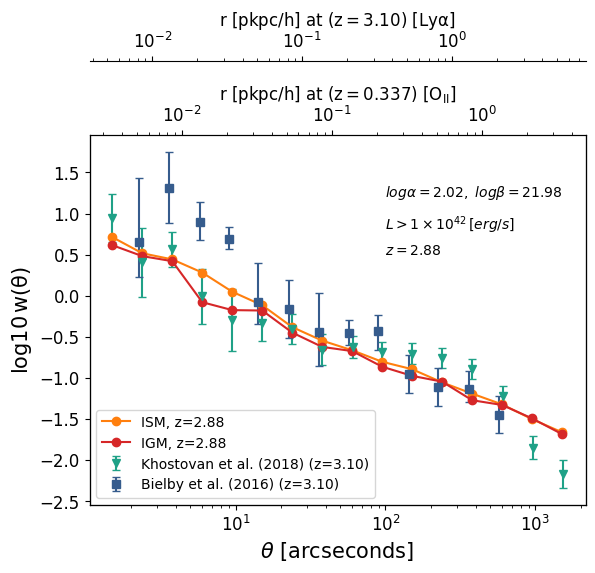

In [12]:
from matplotlib.ticker import FuncFormatter
import math


from matplotlib.pyplot import cm
color_line=cm.viridis(np.linspace(0,1,8))




cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)
littleh = cosmo.H0.value/100.
Mpcph = u.def_unit('Mpcph', u.Mpc/littleh)

d_A = cosmo.angular_diameter_distance(z=3.10)
d_A2 = cosmo.angular_diameter_distance(z=0.337)
d_A = d_A.to(Mpcph)
d_A2 = d_A2.to(Mpcph)

arcsectoradian = np.pi / 180 / 3600
theta_radian = np.array(r_meas_khostovan) * np.pi / 180 / 3600
distance_Mpc = d_A * theta_radian
distance_Mpc2 = d_A2 * theta_radian
h = 67.8/100
dis_Mpc_over_h = distance_Mpc * h
dis_Mpc_over_h2 = distance_Mpc2 * h

@FuncFormatter
def twin1_formatter(x, pos):
    return f'{x * (np.pi / 180 / 3600)*d_A*1000}'


@FuncFormatter
def twin2_formatter(x, pos):
    return f'{x * (np.pi / 180 / 3600)*d_A2*1000}'


fig = plt.figure(figsize=(8,6))

fig, ax = plt.subplots()


ax.set_xscale('log')


twin1 = ax.twiny()
twin1.spines['top'].set_position(('axes', 1.2))
twin1.set_xlabel(r'$\rm r$ [$\rm \mathrm{pkpc}/h$] at ($\rm z=3.10$) $\rm [Ly\alpha]$', fontsize=12)
twin1.xaxis.set_major_formatter(FuncFormatter(twin1_formatter))
twin1.set_xscale('log')
twin1.plot(dis_Mpc_over_h,np.ones_like(dis_Mpc_over_h), alpha=0)

# Adjust the size of ticks and tick labels
twin1.tick_params(axis='both', which='both', labelsize=12)  # Adjust labelsize as needed


twin2 = ax.twiny()
twin2.set_xlabel(r'$\rm r$ [$\rm \mathrm{pkpc}/h$] at ($\rm z=0.337$) $\rm [O_{II}]$', fontsize=12)
twin2.xaxis.set_major_formatter(FuncFormatter(twin2_formatter))
#twin2.xaxis.set_ticks(np.array([0, 1/2, 1, 3/2, 2])*np.pi)
twin2.set_xscale('log')
twin2.plot(dis_Mpc_over_h2,np.ones_like(dis_Mpc_over_h), alpha=0)


twin2.tick_params(axis='both', which='both', labelsize=12)  # Adjust labelsize as needed


r_meas_khostovan = [1.5001173865680846,2.3753841550095163,3.761338902136766,5.982848746241583,9.51641956540266,15.068922239342394,23.968880463189763,37.95389572534231,60.37010313703765,95.16419565402671,151.36976578535385,239.68880463189825,379.5389572534245,603.7010313703769,968.9500062613703,1527.4008686968152]
CF_meas_khostovan = [0.948717948717948,0.405128205128205,0.5658119658119656,-0.008547008547008073,-0.295726495726496,-0.3367521367521369,-0.40170940170940206,-0.654700854700855,-0.6239316239316244,-0.6888888888888891,-0.7059829059829061,-0.7538461538461547,-0.890598290598291,-1.218803418803419,-1.8478632478632475,-2.165811965811966]
err_khostovan = [0.29059829059,0.42393162393,0.21196581196,0.33504273504,0.37264957265,0.21538461538,0.18461538461,0.18803418803,0.12991452991,0.12307692307,0.12649572649,0.11965811965,0.11965811965,0.11623931623,0.13675213675,0.17094017094]


ax.errorbar(r_meas_khostovan,CF_meas_khostovan,yerr=err_khostovan,capsize=3,fmt='v',label='Khostovan et al. (2018) (z=3.10)',color=color_line[4])



r_meas_Bielby = [2.2804717221467325,3.608437803198553,5.7562691648039, 9.034586685607248, 14.122507582288096, 22.80471722146733, 35.7924879256625,57.097061336481694, 89.61505019466041, 144.1219596718855, 225.2857312756656, 357.9248792566254, 568.6566053937552]
CF_meas_Bielby = [0.6552795031055898,1.3136645962732914,0.8944099378881982,0.6863354037267078,-0.07453416149068381,-0.1552795031055907,-0.4347826086956528,-0.4565217391304355,-0.4254658385093171,-0.9503105590062115,-1.1118012422360257,-1.1366459627329197,-1.450310559006212]
err_up = [1.428571428571428-0.6552795031055898,1.7515527950310552-1.3136645962732914,1.1428571428571421-0.8944099378881982,0.8416149068322976-0.6863354037267078,0.4037267080745339+0.07453416149068381,0.1894409937888195+0.1552795031055907,0.031055900621117516+0.4347826086956528,0.4565217391304355-0.29192546583850953,0.4254658385093171-0.22981366459627361,0.9503105590062115-0.7204968944099388,1.1118012422360257-0.8819875776397526,1.1366459627329197-0.9130434782608705,1.450310559006212-1.2236024844720506]
err_bot = [0.6552795031055898-0.22360248447204922,1.3136645962732914-0.885093167701863,0.8944099378881982-0.683229813664596,0.6863354037267078-0.5652173913043472,0.34161490683229845-0.07453416149068381,0.5093167701863361-0.1552795031055907,0.8602484472049698-0.4347826086956528,0.5931677018633548-0.4565217391304355,0.6645962732919259-0.4254658385093171,1.1863354037267086-0.9503105590062115,1.3354037267080754-1.1118012422360257,1.2981366459627335-1.1366459627329197,1.6645962732919255-1.450310559006212]
err_Bielby = np.array([(0.6552795031055898-0.22360248447204922,1.428571428571428-0.6552795031055898), (1.3136645962732914-0.885093167701863,1.7515527950310552-1.3136645962732914), (0.8944099378881982-0.683229813664596,1.1428571428571421-0.8944099378881982),(0.6863354037267078-0.5652173913043472,0.8416149068322976-0.6863354037267078), (0.34161490683229845-0.07453416149068381,0.4037267080745339+0.07453416149068381), (0.5093167701863361-0.1552795031055907,0.1894409937888195+0.1552795031055907), (0.8602484472049698-0.4347826086956528,0.031055900621117516+0.4347826086956528), (0.5931677018633548-0.4565217391304355,0.4565217391304355-0.29192546583850953), (0.6645962732919259-0.4254658385093171,0.4254658385093171-0.22981366459627361), (1.1863354037267086-0.9503105590062115,0.9503105590062115-0.7204968944099388), (1.3354037267080754-1.1118012422360257,1.1118012422360257-0.8819875776397526), (1.2981366459627335-1.1366459627329197,1.1366459627329197-0.9130434782608705), (1.6645962732919255-1.450310559006212,1.450310559006212-1.2236024844720506)]).T


ax.errorbar(r_meas_Bielby,CF_meas_Bielby,yerr=err_Bielby,capsize=3,fmt='s',label='Bielby et al. (2016) (z=3.10)',color=color_line[2])




ax.set_xlabel(r"$\theta$ [$\mathrm{arcseconds}$]", fontsize=15)
ax.set_ylabel(r"$\rm{log10}\,w(\theta)$", fontsize=15)


ax.plot(ISM[:,0],np.log10(ISM[:,1]),'o-',color='C1',label=r'ISM, z=2.88')
ax.plot(IGM[:,0],np.log10(IGM[:,1]),'o-',color='C3',label=r'IGM, z=2.88')


# 2.041392685158225 23.678073664830322
ax.text(100,1.2, r'$log\alpha=2.02,\,\,log\beta=21.98$',color='k')
ax.text(100,0.8, r'$L>1\times10^{42}\,[erg/s]$',color='k')
ax.text(100,0.5, r'$z=2.88$',color='k')


#ax.set_xlim(1,3000)
#ax.set_ylim(-3,2)
ax.legend(loc='lower left')

# Adjust the size of ticks and tick labels
ax.tick_params(axis='both', which='both', labelsize=12)  # Adjust labelsize as needed
